In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
BATCH_SIZE = 256

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [4]:
test_set = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=False,
    transform=transform)
print(' Number of testing data ',len(test_set))

 Number of testing data  10000


In [5]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [6]:
CLASSES = testloader.dataset.classes
print(CLASSES)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
IMAGES = testloader.dataset.data
print("type of images {} , number of images {} shape of images {}".format(type(IMAGES), len(IMAGES), IMAGES.shape))

type of images <class 'torch.Tensor'> , number of images 10000 shape of images torch.Size([10000, 28, 28])


In [8]:
TARGET = testloader.dataset.targets
print(TARGET.shape)

torch.Size([10000])


In [9]:
MODEL_PATH = './fmnist_test.pth'

In [10]:
cnn_layers =  nn.Sequential(
            # Defining a 2D convolution layer
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            # in_channels (int) – Number of channels in the input image. For B&W it is 1.
            # out_channels (int) – Number of channels produced by the convolution. 4 filters
            # kernel_size (int or tuple) – Size of the convolving kernel (3x3)
            # stride (int or tuple, optional) – Stride of the convolution
            # padding (int or tuple, optional) – Padding of 1 added to both sides of the input
            # example x1 = (n, c=1 , h=28 , w=28 )
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1), #in_channels = 1 is a data dependent hyperparameter. It is 1 because the images are in grayscale
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.BatchNorm2d(4), # Normalize output from the activation function. 
            nn.ReLU(inplace=True), # negative elements to zero
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.MaxPool2d(kernel_size=2, stride=2), #Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on
            # x3 = (n, c=4 , h=14 , w=14 )
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.BatchNorm2d(4), # 4 features
            nn.ReLU(inplace=True), # inplace = True will modify the input directly, without allocating any additional output.
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.MaxPool2d(kernel_size=2, stride=2), # Downsamples the input representation by taking the maximum value
            # x4 = (n, c=4 , h=7 , w=7 )
        )

In [11]:
linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 10) 
#10 outputs because MNIST Fashion has 10 different classes. It is a data dependent hyperparameter
)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layer = cnn_layers
        self.linear_layer = linear_layers
    def forward(self, x):
        x = self.cnn_layer(x)
        x = x.view(x.shape[0],-1)
        x = self.linear_layer(x)
        return x

In [13]:
model = Net()

In [14]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [15]:
result = []
for i,data in enumerate(testloader, 0):
    image, label = data
    # evaluate model:
    model.eval()
    with torch.no_grad():
        output  = model(image)
    result.append(output)
print("all done")

all done


In [16]:
print(output.shape)

torch.Size([16, 10])


In [17]:
predictions = torch.cat(result, dim=0)
print(predictions.shape)

torch.Size([10000, 10])


In [18]:
print("Logits for first index", predictions[0])

Logits for first index tensor([ -8.4849, -17.1438, -10.9654, -13.5977, -16.1636,   6.5670, -11.4565,
          8.0011,  -2.1616,  11.9731])


In [19]:
softmax = torch.nn.Softmax(dim=1) 
prediction = softmax(predictions)
print("After using softmax", prediction[0])

After using softmax tensor([1.2741e-09, 2.2114e-13, 1.0664e-10, 7.6691e-12, 5.8932e-13, 4.3868e-03,
        6.5259e-11, 1.8406e-02, 7.1020e-07, 9.7721e-01])


tensor(1.0000)
tensor(9)
tensor(9)


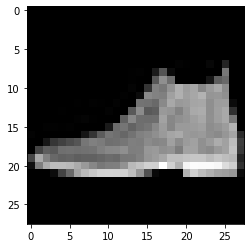

Ankle boot


In [20]:
print(prediction[0].sum())
print(prediction[0].argmax(dim=0))
print(TARGET[0])
plt.figure()
counter = 0
plt_image = IMAGES[0].numpy()
plt.imshow(plt_image, cmap='gray')
plt.show()
print(CLASSES[prediction[0].argmax(dim=0)])

In [21]:
print(TARGET.shape)

torch.Size([10000])


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [23]:
import itertools
def custom_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
cm = confusion_matrix(y_pred=prediction.argmax(dim=1), y_true=TARGET)

courtesy of deep lizard.com https://deeplizard.com/learn/video/0LhiS6yu2qQ
Normalized confusion matrix


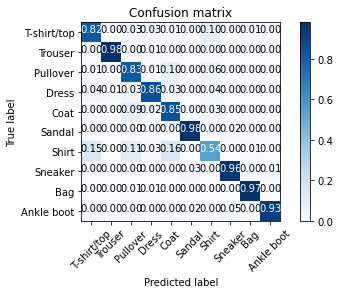

In [25]:
print("courtesy of deep lizard.com {}".format("https://deeplizard.com/learn/video/0LhiS6yu2qQ"))
custom_plot_confusion_matrix(cm, classes = CLASSES, normalize=True)
#normalize 

In [26]:
acc = accuracy_score(y_pred=prediction.argmax(dim=1), y_true=TARGET)
f1 = f1_score(y_pred=prediction.argmax(dim=1), y_true=TARGET, average='weighted')

In [27]:
print("accuracy is {}, and the weighted f1 score is {}".format(acc,f1.round(4)))

accuracy is 0.8715, and the weighted f1 score is 0.8695


In [28]:
Y_PREDS = prediction.argmax(dim=1)
print(Y_PREDS)

tensor([9, 2, 1,  ..., 8, 1, 5])


In [29]:
RESULTS = (TARGET == Y_PREDS)

In [30]:
print(RESULTS)

tensor([True, True, True,  ..., True, True, True])


In [31]:
correct = []
incorrect = []
for i, res in enumerate(RESULTS,0):
    if res:
        correct.append(i)
    else:
        incorrect.append(i)

In [32]:
print(len(correct))
print(len(incorrect))

8715
1285


In [55]:
import random
random_correct = random.sample(correct, k=5)
random_incorrect = random.sample(incorrect, k=5)
print(random_correct, random_incorrect)

[7788, 5603, 8427, 8885, 2946] [3468, 2659, 6859, 1374, 6547]


In [71]:
second_pred_values, second_pred_indices = torch.topk(prediction,k=2, dim=1)

In [72]:
def get_second_guess_index(index):
    return second_pred_indices[:][index][1].item()

In [73]:
get_second_guess_index(1) #second guess

6

In [74]:
second_pred_values[0]

tensor([0.9772, 0.0184])

In [75]:
round((second_pred_values[0][0]*100).item(),2)

97.72

In [76]:
def getImageTitle(index):
    truth = TARGET[index]
    truth_class = CLASSES[truth]
    pred = Y_PREDS[index]
    pred_prob = round((second_pred_values[index][0]*100).item(),2)
    second_pred_prob = round((second_pred_values[index][1]*100).item(),2)
    # show prediction probabilities 
    pred_class = CLASSES[pred]
    second_pred = get_second_guess_index(index)
    second_pred_class = CLASSES[second_pred]
    label = "actual {} , prediction {} {}%, 2nd prediction {} {}%".format(truth_class,pred_class,pred_prob, second_pred_class, second_pred_prob)
    return label

In [77]:
random_correct_images = []
for img_index in random_correct:
    random_correct_images.append(IMAGES[img_index])
print(len(random_correct_images))

5


In [78]:
random_incorrect_images = []
for img_index in random_incorrect:
    random_incorrect_images.append(IMAGES[img_index])
print(len(random_incorrect_images))

5


In [79]:
random_correct_images[4].shape

torch.Size([28, 28])

<Figure size 432x288 with 0 Axes>

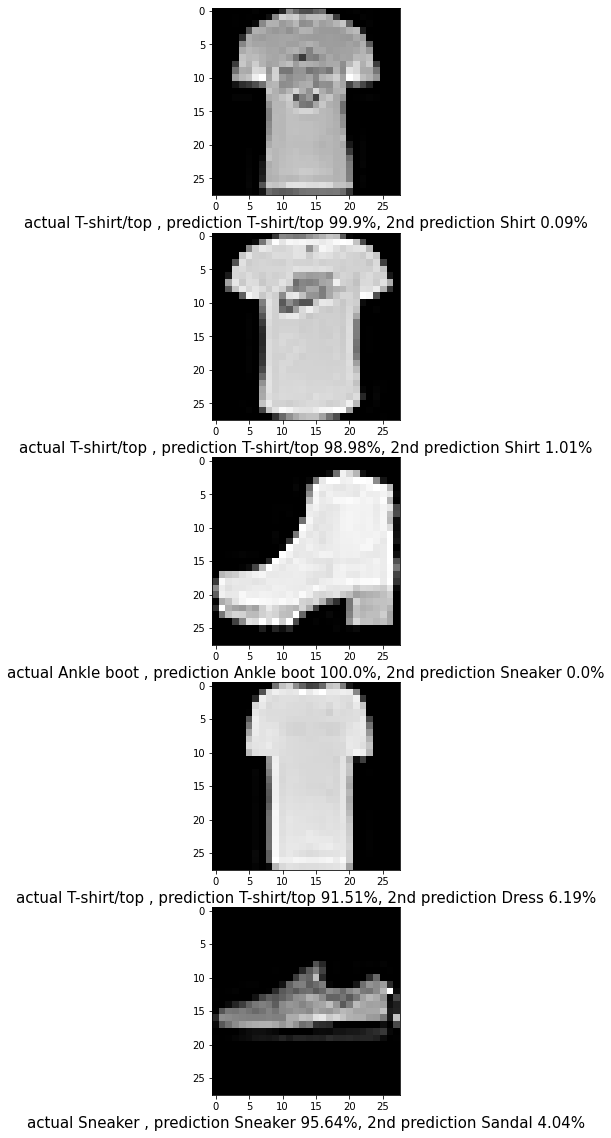

<Figure size 720x360 with 0 Axes>

In [80]:
plt.figure()
plt_row = 1
plt_col = 5
fig, axes = plt.subplots(5, figsize=(20,20))
counter = 0
plt.figure(figsize=(10,5))
for j in range(plt_col):
    plt_image = random_correct_images[counter].numpy()
    axes[j].imshow(plt_image, cmap='gray')
    axes[j].set_xlabel(getImageTitle(random_correct[counter]),fontsize=15 )
    counter = counter + 1
plt.show()

<Figure size 432x288 with 0 Axes>

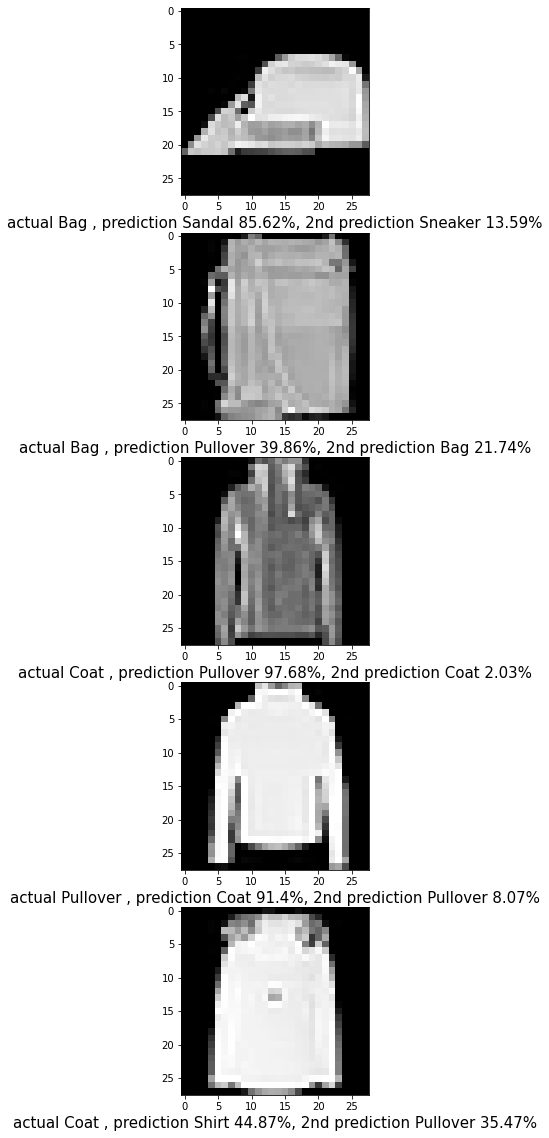

<Figure size 720x360 with 0 Axes>

In [81]:
plt.figure()
plt_row = 1
plt_col = 5
fig, axes = plt.subplots(5, figsize=(20,20))
counter = 0
plt.figure(figsize=(10,5))
for j in range(plt_col):
    plt_image = random_incorrect_images[counter].numpy()
    axes[j].imshow(plt_image, cmap='gray')
    axes[j].set_xlabel(getImageTitle(random_incorrect[counter]),fontsize=15 )
    counter = counter + 1
plt.show()

In [82]:
print(second_pred_values[random_correct])
print(second_pred_values[random_incorrect])

tensor([[9.9904e-01, 9.1972e-04],
        [9.8983e-01, 1.0116e-02],
        [1.0000e+00, 7.4207e-07],
        [9.1514e-01, 6.1904e-02],
        [9.5636e-01, 4.0431e-02]])
tensor([[0.8562, 0.1359],
        [0.3986, 0.2174],
        [0.9768, 0.0203],
        [0.9140, 0.0807],
        [0.4487, 0.3547]])
